# UNet

In [85]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, leaky_relu, sigmoid
from tqdm.auto import tqdm
import torch.optim as optim
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_a, plot_b, plot_rgb, reconstruct_lab, plot_predicted_image, plot_ab
from utils.models import save_model, load_model

In [86]:
torch.backends.mps.is_available()

True

In [87]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

## Data import

In [88]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [89]:
path = '../train2014'
dataset = CocoDataset(path, transform=transform)

Found 82783 images.


In [90]:
image, l_channel, a_channel, b_channel, ab_channels = dataset[0]

In [91]:
image.shape, l_channel.shape, a_channel.shape, b_channel.shape, ab_channels.shape

(torch.Size([3, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([64, 64]),
 torch.Size([64, 64]),
 torch.Size([2, 64, 64]))

## Data preparation

In [92]:
test_size = int(.2 * len(dataset))
train_size = len(dataset) - test_size

In [93]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [94]:
for x in train_loader:
    print(len(x))
    print(f"Image shape {x[0].shape}\nL shape {x[1].shape}\nA shape {x[2].shape}\nB shape {x[3].shape}\nAB shape {x[4].shape}")
    break

5
Image shape torch.Size([64, 3, 64, 64])
L shape torch.Size([64, 1, 64, 64])
A shape torch.Size([64, 64, 64])
B shape torch.Size([64, 64, 64])
AB shape torch.Size([64, 2, 64, 64])


## UNet model

In [95]:
torch.manual_seed(42)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

In [96]:
len(small_train), len(small_test)

(5000, 1000)

### Training

In [97]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)

        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv9 = nn.Conv2d(256, 256, 3, padding=1)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)

        self.conv10 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv11 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, 3, padding=1)
        self.maxpool4 = nn.MaxPool2d(2, stride=2)

        self.conv13 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv14 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.conv15 = nn.Conv2d(1024, 1024, 3, padding=1)
        self.up1 = nn.ConvTranspose2d(1024, 512, 3, stride=2, padding=1, output_padding=1)

        self.conv16 = nn.Conv2d(1024, 512, 3, padding=1)
        self.conv17 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv18 = nn.Conv2d(512, 512, 3, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)

        self.conv19 = nn.Conv2d(512, 256, 3, padding=1)
        self.conv20 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv21 = nn.Conv2d(256, 256, 3, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)

        self.conv22 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv23 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv24 = nn.Conv2d(128, 128, 3, padding=1)
        self.up4 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)

        self.conv25 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv26 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv27 = nn.Conv2d(64, 64, 3, padding=1)
        self.output = nn.Conv2d(64, 2, 1, padding=0)

    def forward(self, x):
        x1 = leaky_relu(self.conv1(x), negative_slope=0.2)
        x1 = leaky_relu(self.conv2(x1), negative_slope=0.2)
        x1 = leaky_relu(self.conv3(x1), negative_slope=0.2)
        x = self.maxpool1(x1)

        x2 = leaky_relu(self.conv4(x), negative_slope=0.2)
        x2 = leaky_relu(self.conv5(x2), negative_slope=0.2)
        x2 = leaky_relu(self.conv6(x2), negative_slope=0.2)
        x = self.maxpool2(x2)

        x3 = leaky_relu(self.conv7(x), negative_slope=0.2)
        x3 = leaky_relu(self.conv8(x3), negative_slope=0.2)
        x3 = leaky_relu(self.conv9(x3), negative_slope=0.2)
        x = self.maxpool3(x3)

        x4 = leaky_relu(self.conv10(x), negative_slope=0.2)
        x4 = leaky_relu(self.conv11(x4), negative_slope=0.2)
        x4 = leaky_relu(self.conv12(x4), negative_slope=0.2)
        x = self.maxpool4(x4)

        x = leaky_relu(self.conv13(x), negative_slope=0.2)
        x = leaky_relu(self.conv14(x), negative_slope=0.2)
        x = leaky_relu(self.conv15(x), negative_slope=0.2)
        x = self.up1(x)

        x = torch.cat([x4, x], dim=1)
        x = leaky_relu(self.conv16(x), negative_slope=0.2)
        x = leaky_relu(self.conv17(x), negative_slope=0.2)
        x = leaky_relu(self.conv18(x), negative_slope=0.2)
        x = self.up2(x)

        x = torch.cat([x3, x], dim=1)
        x = leaky_relu(self.conv19(x), negative_slope=0.2)
        x = leaky_relu(self.conv20(x), negative_slope=0.2)
        x = leaky_relu(self.conv21(x), negative_slope=0.2)
        x = self.up3(x)

        x = torch.cat([x2, x], dim=1)
        x = leaky_relu(self.conv22(x), negative_slope=0.2)
        x = leaky_relu(self.conv23(x), negative_slope=0.2)
        x = leaky_relu(self.conv24(x), negative_slope=0.2)
        x = self.up4(x)

        x = torch.cat([x1, x], dim=1)
        x = leaky_relu(self.conv25(x), negative_slope=0.2)
        x = leaky_relu(self.conv26(x), negative_slope=0.2)
        x = leaky_relu(self.conv27(x), negative_slope=0.2)
        x = self.output(x)

        return torch.sigmoid(x)

In [99]:
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)

In [100]:
NUM_EPOCHS =10
train_losses = []
test_losses = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss =  0.0

    model.train()
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True)
    for _, l_channels, _, _, ab_channels in progress_bar:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
    
    train_losses.append(running_loss / len(small_train_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}")
    
    # test loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)
            
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            test_loss += loss.item()
        
    test_loss /= len(small_test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {test_loss}")
    
print('Finished Training')

Epoch 1/10:   0%|          | 0/79 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

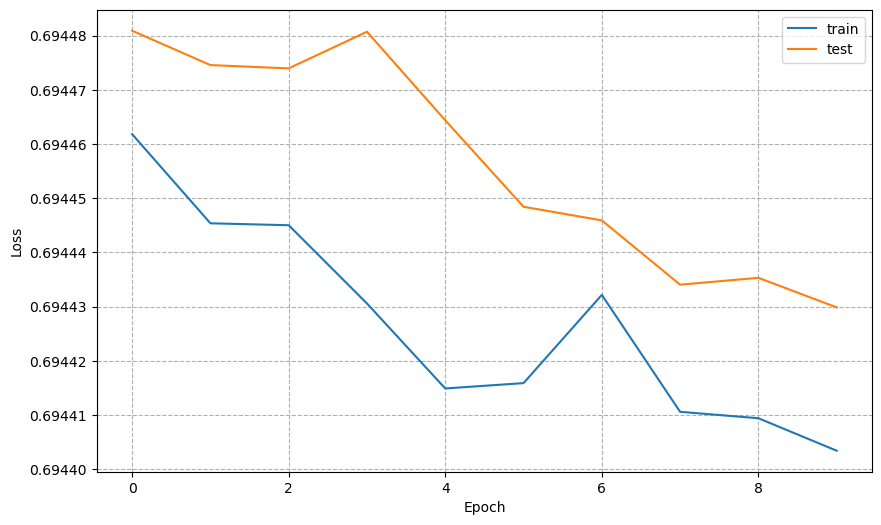

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

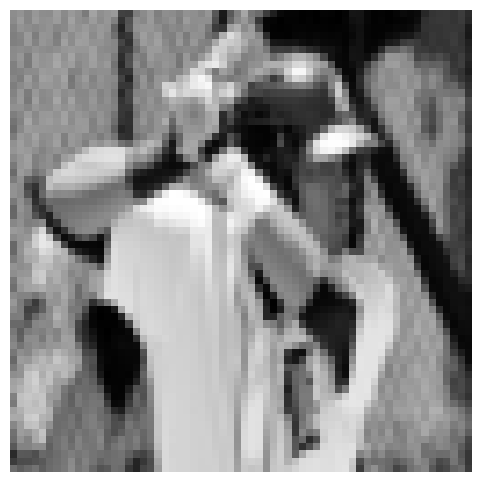

In [60]:
plot_l(dataset[0][1])

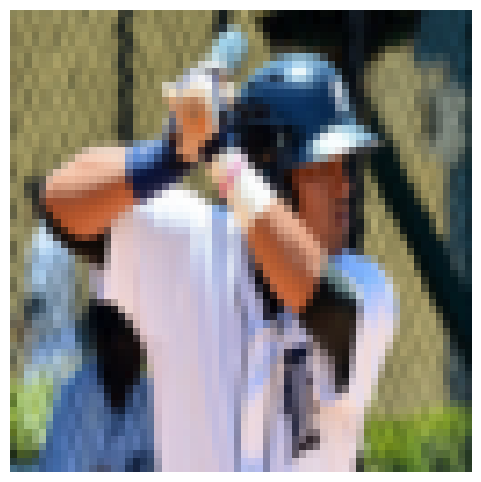

In [61]:
reconstruct_lab(dataset[0][1], dataset[0][-1])

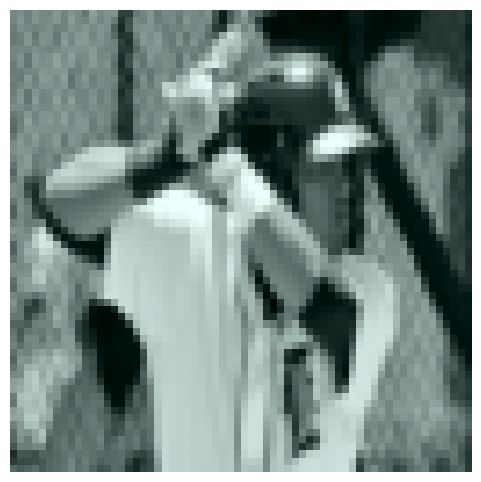

In [75]:
input = dataset[0][1].to(device).unsqueeze(0)
ab = model(input).squeeze(0)
reconstruct_lab(dataset[0][1].to(device).detach().cpu(), ab.detach().cpu())

## Save Model

In [76]:
save_model(model, 'unet_sgd_bce')

Model saved to models/unet_sgd_bce.pth successfully!


In [101]:
loaded_model = load_model(UNet(), 'models/unet_l1.pth').to(device)

UNet model loaded successfully!


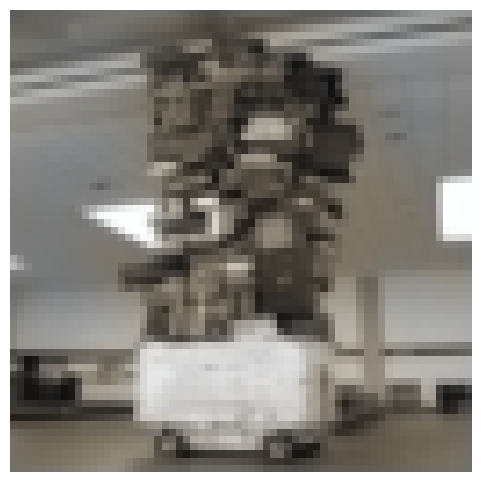

In [102]:
input = dataset[5000][1].to(device).unsqueeze(0)
ab = loaded_model(input).squeeze(0)
reconstruct_lab(dataset[5000][1].to(device).detach().cpu(), ab.detach().cpu())

In [66]:
loaded_model_2 = load_model(UNet(), 'models/unet_bce.pth').to(device)

UNet model loaded successfully!


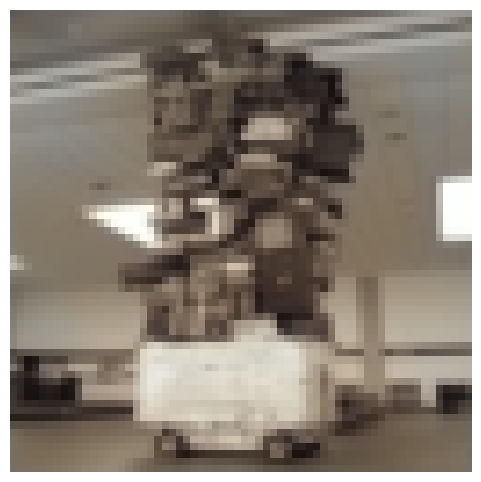

In [67]:
input = dataset[5000][1].to(device).unsqueeze(0)
ab = loaded_model_2(input).squeeze(0)
reconstruct_lab(dataset[5000][1].to(device).detach().cpu(), ab.detach().cpu())

In [68]:
loaded_model_2.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model_2(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0028
Average PSNR: 50.9706


In [69]:
loaded_model.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0030
Average PSNR: 50.4212
